# IA EN EL MERCADO LABORAL: SALARIOS, HABILIDADES Y RIESGOS

Marta Vaquerizo, Paula Ibañez y Laura Riera

**Objetivos**:

- Predicción:

    1. Construir un modelo predictivo para estimar los salarios en función de las características clave.
    2. Predecir las habilidades que influyen a la hora de tienen salarios más altos. 
    3. Identificar los factores clave que aumentan la probabilidad de que la IA sustituya puestos de trabajo dependiendo del sector, de ubicacion...
    

- Toma de decisiones:

    - Proporcionar insights para estrategias en contratación y gestión laboral.

### ACALARACIONES PREVIAS

Los resultados de los modelos predictivos llevados a cabo en este análisis no son significativos debido a:
>1) La poca variabilidad en los datos

>2) La poca correlación entre variables


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore') # Para evitar avisos moelstos
%matplotlib inline

In [76]:
df_ia = pd.read_csv('ai_job_market_insights.csv')
df_ia.head(20)

,Job_Title,Industry,Company_Size,Location,AI_Adoption_Level,Automation_Risk,Required_Skills,Salary_USD,Remote_Friendly,Job_Growth_Projection
0,Cybersecurity Analyst,Entertainment,Small,Dubai,Medium,High,UX/UI Design,111392.165243,Yes,Growth
1,Marketing Specialist,Technology,Large,Singapore,Medium,High,Marketing,93792.562466,No,Decline
2,AI Researcher,Technology,Large,Singapore,Medium,High,UX/UI Design,107170.263069,Yes,Growth
3,Sales Manager,Retail,Small,Berlin,Low,High,Project Management,93027.953758,No,Growth
4,Cybersecurity Analyst,Entertainment,Small,Tokyo,Low,Low,JavaScript,87752.922171,Yes,Decline
5,UX Designer,Education,Large,San Francisco,Medium,Medium,Cybersecurity,102825.007867,No,Growth
6,HR Manager,Finance,Medium,Singapore,Low,High,Sales,102065.720673,Yes,Growth
7,Cybersecurity Analyst,Technology,Small,Dubai,Medium,Low,Machine Learning,86607.317618,Yes,Decline
8,AI Researcher,Retail,Large,London,High,Low,JavaScript,75015.860846,No,Stable
9,Sales Manager,Entertainment,Medium,Singapore,High,Low,Cybersecurity,96834.578295,Yes,Decline


In [77]:
# Haremos por seguridad una copia del marco de datos original antes de su procesamiento posterior 
data = df_ia.copy()

## Prediccion 1: Estimación Salarial

Predecir el salario basado en las caracteristicas del empleo

### Seleccionar variables relevantes para la predicción de salarios

In [78]:
# Extrayendo nuestra variable objetivo 'Outcome'
# y creando una lista de características útiles de las variables dependientes
target = 'Salary_USD'
features_list = list(data.columns)
features_list.remove(target)
print(features_list)

['Job_Title', 'Industry', 'Company_Size', 'Location', 'AI_Adoption_Level', 'Automation_Risk', 'Required_Skills', 'Remote_Friendly', 'Job_Growth_Projection']


In [79]:
data[target].describe()

count       500.000000
mean      91222.390974
std       20504.291453
min       31969.526346
25%       78511.514863
50%       91998.195286
75%      103971.282092
max      155209.821614
Name: Salary_USD, dtype: float64

### Convertir variables categóricas en dummies

In [80]:
# Variable objetivo
target = 'Salary_USD'

# Crear una lista de características útiles excluyendo la variable objetivo
features_list = list(data.columns)
features_list.remove(target)
print("Variables seleccionadas (sin el target):", features_list)

# Generar dummies solo para las variables categóricas seleccionadas
categorical_columns = ['Job_Title', 'Industry', 'Location', 'Remote_Friendly', 'Required_Skills']

# Excluir la variable objetivo antes de generar dummies
data_encoded_sin_distancia = pd.get_dummies(
    data[categorical_columns], 
    drop_first=False  # No eliminamos categorías de referencia
)

# Crear un mapeo para asignar valores a las categorías con distancia
mapping = {
    'Company_Size': {'Small': 0, 'Medium': 1, 'Large': 2},
    'AI_Adoption_Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Automation_Risk': {'Low': 0, 'Medium': 1, 'High': 2},
    'Job_Growth_Projection': {'Decline': 0, 'Stable': 1, 'Growth': 2}
}

# Crear una copia del DataFrame original para codificación con distancia
data_encoded_con_distancia = data.copy()

# Aplicar el mapeo a cada columna categórica con distancia
for col, col_map in mapping.items():
    if col != target:  # Excluir la variable objetivo al aplicar el mapeo
        data_encoded_con_distancia[col] = data_encoded_con_distancia[col].map(col_map)

# Eliminar las columnas categóricas originales (excluyendo el target)
data_encoded_con_distancia.drop(columns=categorical_columns, inplace=True)

# Unir ambos DataFrames: con y sin distancia
data_encoded_full = pd.concat([data_encoded_con_distancia, data_encoded_sin_distancia], axis=1)

# Verificar que la variable objetivo sigue intacta
print("Columnas del DataFrame final:", data_encoded_full.columns)


Variables seleccionadas (sin el target): ['Job_Title', 'Industry', 'Company_Size', 'Location', 'AI_Adoption_Level', 'Automation_Risk', 'Required_Skills', 'Remote_Friendly', 'Job_Growth_Projection']
Columnas del DataFrame final: Index(['Company_Size', 'AI_Adoption_Level', 'Automation_Risk', 'Salary_USD',
       'Job_Growth_Projection', 'Job_Title_AI Researcher',
       'Job_Title_Cybersecurity Analyst', 'Job_Title_Data Scientist',
       'Job_Title_HR Manager', 'Job_Title_Marketing Specialist',
       'Job_Title_Operations Manager', 'Job_Title_Product Manager',
       'Job_Title_Sales Manager', 'Job_Title_Software Engineer',
       'Job_Title_UX Designer', 'Industry_Education', 'Industry_Energy',
       'Industry_Entertainment', 'Industry_Finance', 'Industry_Healthcare',
       'Industry_Manufacturing', 'Industry_Retail', 'Industry_Technology',
       'Industry_Telecommunications', 'Industry_Transportation',
       'Location_Berlin', 'Location_Dubai', 'Location_London',
       'Location

In [81]:
# Separar X e y
target = 'Salary_USD'
X = data_encoded_full.drop(columns=[target])  # Excluir explícitamente el target de X
y = data_encoded_full[target]  # Asignar el target a y


### Seleccionar características clave

In [82]:
###  Revisar la correlación entre las variables dummies ###
# Calcular la correlación entre las variables dummies
correlation_matrix = X.corr()

# Identificar pares altamente correlacionados
correlated_pairs = []
threshold = 0.1  # Umbral de correlación
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and correlation_matrix.loc[col1, col2] > threshold:
            correlated_pairs.append((col1, col2, correlation_matrix.loc[col1, col2]))

# Mostrar las variables con alta correlación
print("Pares de variables correlacionadas (> 0.1):")
for pair in correlated_pairs:
    print(pair)

Pares de variables correlacionadas (> 0.1):
('Company_Size', 'Location_Toronto', 0.10131870846752099)
('Job_Growth_Projection', 'Job_Title_Operations Manager', 0.10303840764938847)
('Job_Title_AI Researcher', 'Remote_Friendly_No', 0.1004738575660157)
('Job_Title_AI Researcher', 'Required_Skills_JavaScript', 0.10524999337851025)
('Job_Title_HR Manager', 'Industry_Finance', 0.10135508436007105)
('Job_Title_Marketing Specialist', 'Industry_Retail', 0.10767575730692122)
('Job_Title_Operations Manager', 'Job_Growth_Projection', 0.10303840764938847)
('Job_Title_UX Designer', 'Remote_Friendly_No', 0.1044919660874623)
('Job_Title_UX Designer', 'Required_Skills_Project Management', 0.14911508218840616)
('Industry_Finance', 'Job_Title_HR Manager', 0.10135508436007105)
('Industry_Finance', 'Location_San Francisco', 0.10700036199460555)
('Industry_Healthcare', 'Location_Paris', 0.12812408973088388)
('Industry_Retail', 'Job_Title_Marketing Specialist', 0.10767575730692122)
('Industry_Technology', '

## Baseline Algorithms

In [83]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Semilla fija para reproducibilidad
seed = 42

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Lista de modelos de regresión a evaluar
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge(alpha=1.0)))
models.append(('Lasso Regression', Lasso(alpha=0.01)))
models.append(('ElasticNet', ElasticNet(alpha=0.01, l1_ratio=0.5)))
models.append(('Random Forest', RandomForestRegressor(n_estimators=100, random_state=seed)))
models.append(('Decision Tree', DecisionTreeRegressor(random_state=seed)))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=seed, n_jobs=-1)))

# Evaluar cada modelo
results = []
model_names = []

for name, model in models:
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Guardar resultados
    results.append((name, rmse, r2))
    model_names.append(name)

# Mostrar los resultados
print("Modelo\t\t\t RMSE\t\t R²")
for name, rmse, r2 in results:
    print(f"{name:<20} {rmse:.3f}\t {r2:.3f}")


Modelo			 RMSE		 R²
Linear Regression    23140.700	 -0.035
Ridge Regression     23084.189	 -0.030
Lasso Regression     23123.179	 -0.034
ElasticNet           23048.442	 -0.027
Random Forest        22906.429	 -0.014
Decision Tree        27524.116	 -0.465
KNN                  24039.225	 -0.117
XGBoost              25635.254	 -0.271


> Cuando la predicción coincide con la esperanza de los valores de la variable objetivo, el resultado de R2 es 0. Aunque este valor debería ser positivo, cuando las predicciones son malas, este valor puede ser negativo. 
> Por tanto, elegimos los dos modelos que tienen los valores de R^2 más próximos a 0; es decir, Random Forest y Elastic Net


De todos los posibles modelos, ajustamos los parámetros de los 2 mejores, que son Elastic Net y Random Forest y elegimos el mejor para definir el modelo final.

### Random Forest con Validación Cruzada e  Hiperparámetros ajustados
Intentamos modificar los hiperparametros del random forest para ver si mejora el resultado de RMSE

In [84]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Semilla fija para reproducibilidad
seed = 42

# Definir el modelo base
rf = RandomForestRegressor(random_state=seed)

# Configurar los hiperparámetros para la búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Evaluar el modelo ajustado en el conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE en el conjunto de prueba: {rmse:.3f}")
print(f"R² en el conjunto de prueba: {r2:.3f}")

# Validación cruzada del modelo final
cv_scores = cross_val_score(best_rf, X, y, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-cv_scores)
print(f"RMSE promedio de validación cruzada: {cv_rmse.mean():.3f} (+/- {cv_rmse.std():.3f})")



Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
RMSE en el conjunto de prueba: 22957.636
R² en el conjunto de prueba: -0.019
RMSE promedio de validación cruzada: 21324.337 (+/- 1495.966)


### Elastic Net con Validación Cruzada e  Hiperparámetros ajustados


In [85]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el espacio de búsqueda de hiperparámetros para ElasticNet
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],       # Regularización
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # Proporción L1/L2
}

# Configurar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=ElasticNet(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    cv=5,       # Validación cruzada con 5 particiones
    scoring='neg_mean_squared_error',  # Métrica a optimizar
    verbose=2,
    random_state=42,
    n_jobs=-1   # Usa todos los núcleos disponibles
)

# Entrenar la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores parámetros:", random_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = ElasticNet(
    alpha=random_search.best_params_['alpha'],
    l1_ratio=random_search.best_params_['l1_ratio'],
    random_state=42
)

best_model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo 
y_pred = best_model.predict(X_test)


# Calcular métricas
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
r2_xgb = r2_score(y_test, y_pred)

print(f"RMSE en el conjunto de prueba: {rmse_xgb:.3f}")
print(f"R² en el conjunto de prueba: {r2_xgb:.3f}")

# Validación cruzada del modelo final
cv_scores_xgb = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
cv_rmse_xgb = np.sqrt(-cv_scores_xgb)
print(f"RMSE promedio de validación cruzada: {cv_rmse_xgb.mean():.3f} (+/- {cv_rmse_xgb.std():.3f})")



Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores parámetros: {'l1_ratio': 0.9, 'alpha': 100}
RMSE en el conjunto de prueba: 22753.494
R² en el conjunto de prueba: -0.001
RMSE promedio de validación cruzada: 20488.572 (+/- 1363.240)
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, 

[CV] END ............................alpha=0.1, l1_ratio=0.9; total time=   0.2s
[CV] END ............................alpha=0.1, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.9; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.3; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.3; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.3; total time=   0.2s
[CV] END ..............................alpha=1, l1_ratio=0.3; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.9; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.9; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.9; total time=   0.1s
[CV] END .............................alpha=10, l1_ratio=0.1; total time=   0.0s
[CV] END .............................alpha=10, l1_ratio=0.7; total time=   0.1s
[CV] END ...................

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_est

### **Conclusiones**

Aunque el RMSE y $R^2$ en los modelos más sencillos parecen mejores, no garantizan un buen rendimiento en datos futuros. Las métricas obtenidas con validación cruzada son más representativas de cómo el modelo funcionará en el mundo real.

Teniendo en cuenta esto, el modelo que mejores métricas tiene es el **Elastic Net** por tanto se convierte en nuestro modelo final. 



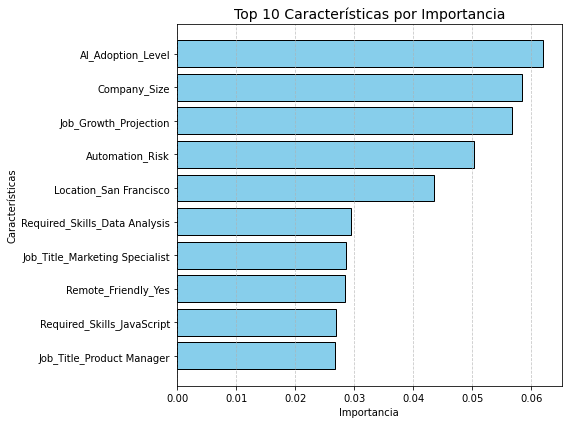

In [14]:
import matplotlib.pyplot as plt
import numpy as np


feature_importances = best_model.feature_importances_

# Ordenar las características por importancia
sorted_idx = np.argsort(feature_importances)[-10:]  # Seleccionar las 15 características más importantes
sorted_features = X.columns[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Crear el gráfico con mejoras
plt.figure(figsize=(8, 6))  # Ajustar el tamaño del gráfico
plt.barh(sorted_features, sorted_importances, color='skyblue', edgecolor='black')
plt.xlabel("Importancia", fontsize=10)
plt.ylabel("Características", fontsize=10)
plt.title("Top 10 Características por Importancia", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Añadir una cuadrícula ligera para facilitar la lectura
plt.tight_layout()  # Ajustar automáticamente los elementos para evitar solapamientos
plt.show()


Este gráfico muestra las features que más influyen a la hora de predecir los salarios. 

## Predicción 2: Habilidades para Incrementar el Salario



>Predecir que habildiades van a tener los salarios más altos para elebarorar un sistema de recomendación para trabajadores. 

- Problema: Identificar qué habilidades tienen más impacto en los salarios altos.
- Objetivo: Crear un sistema que sugiera habilidades clave para mejorar las oportunidades salariales. 

In [35]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
import numpy as np

In [65]:
#Paso 1: Cargar datos
df_ia = pd.read_csv('ai_job_market_insights.csv')
data=df_ia.copy()

# Paso 2: Crear la variable `High_Salary`
# Definir salarios altos como aquellos mayores al percentil 75
data['High_Salary'] = (data['Salary_USD'] > data['Salary_USD'].quantile(0.75)).astype(int)

    #1: Salarios superiores al quartil 75
    #0: Salarios inferriores al quartil 75

# Paso 3: Codificar las habilidades (Required_Skills)
# Crear columnas binarias a partir de las habilidades
skills_data = data['Required_Skills'].str.get_dummies(sep=', ') #0: no se requiere esa habilidad; 1: el empleo sí se requiere la habilidad

# Paso 4: Definir las variables predictoras y la variable objetivo
# Usar las habilidades como variables predictoras
X_skills = skills_data  # Variables binarias de habilidades
y_skills = data['High_Salary']  # Variable objetivo (Salarios altos)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_skills, X_test_skills, y_train_skills, y_test_skills = train_test_split(
    X_skills, y_skills, test_size=0.2, random_state=42
)

# Paso 5: Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_skills_balanced, y_train_skills_balanced = smote.fit_resample(X_train_skills, y_train_skills)

## Baseline Algorithms

In [37]:

# Modelos de clasificación
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(random_state=42, probability=True)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

# Métricas de evaluación
scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'F1': make_scorer(f1_score),
    'ROC-AUC': 'roc_auc'
}

# Resultados para almacenar métricas
results = []

for name, model in models:
    model_results = {}
    model_results['Model'] = name

    for metric_name, scorer in scorers.items():
        cv_scores = cross_val_score(model, X_train_skills_balanced, y_train_skills_balanced, scoring=scorer, cv=5)
        model_results[metric_name] = np.mean(cv_scores)

    results.append(model_results)

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar los resultados ordenados por F1-Score
results_df.sort_values(by='F1', ascending=False)


,Model,Accuracy,F1,ROC-AUC
0,Logistic Regression,0.590814,0.587178,0.620251
1,Random Forest,0.590814,0.587178,0.627237
2,Decision Tree,0.590814,0.587178,0.627137
4,SVM,0.590814,0.587178,0.590555
5,XGBoost,0.590814,0.587178,0.624022
3,KNN,0.521488,0.130845,0.586913


Las métricas accuracy y F1 score son muy similares o incluso iguales en todos los modelos evaluados. 

Las únicas diferencias son en términos del Roc-auc por lo que usamos esta métrica para seleccionar a los dos mejores modelos: 

    - Random Forest: 0.627237
    - XGBoost: 0.624022

### Random Forest con Validación cruzada y ajuste de hiperparámetros


Resultados para Random Forest:
              precision    recall  f1-score   support

     No Alto       0.67      0.56      0.61        72
        Alto       0.20      0.29      0.24        28

    accuracy                           0.48       100
   macro avg       0.43      0.42      0.42       100
weighted avg       0.54      0.48      0.50       100


Habilidades más importantes para un salario alto (Random Forest):
                Skill  Importance
3          JavaScript    0.362889
5           Marketing    0.171179
8               Sales    0.088425
6  Project Management    0.061482
4    Machine Learning    0.059557
0       Communication    0.058288
1       Cybersecurity    0.056615
9        UX/UI Design    0.050568
7              Python    0.045513
2       Data Analysis    0.045484


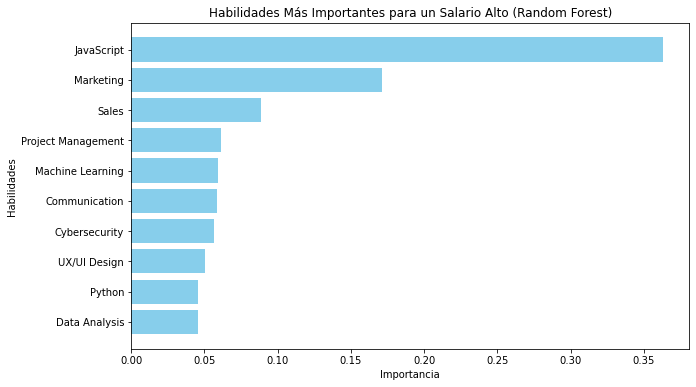

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Definir espacio de búsqueda de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Configurar búsqueda aleatoria para Random Forest
grid_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=50,  # Número de combinaciones aleatorias
    scoring='f1',  # Usar F1 como métrica de evaluación
    cv=5,  # Validación cruzada
    random_state=42,
    n_jobs=-1
)

# Ajustar Random Forest con validación cruzada
#print("Optimizando Random Forest...")
grid_search_rf.fit(X_train_skills_balanced, y_train_skills_balanced)

# Mejores hiperparámetros encontrados
#print("\nMejores hiperparámetros encontrados (Random Forest):")
#print(grid_search_rf.best_params_)

# Evaluación del modelo Random Forest
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_skills)

print("\nResultados para Random Forest:")
print(classification_report(y_test_skills, y_pred_rf, target_names=['No Alto', 'Alto']))
#print(confusion_matrix(y_test_skills, y_pred_rf))

# Importancia de características Random Forest
feature_importances_rf = pd.DataFrame({
    'Skill': X_train_skills_balanced.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nHabilidades más importantes para un salario alto (Random Forest):")
print(feature_importances_rf.head(10))

# Visualización de las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_rf.head(10)['Skill'], feature_importances_rf.head(10)['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Habilidades')
plt.title('Habilidades Más Importantes para un Salario Alto (Random Forest)')
plt.gca().invert_yaxis()
plt.show()


### XGBoost con Validación cruzada y ajuste de hiperparámetros

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Definir espacio de búsqueda de hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'subsample': [0.6, 0.8, 1],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 2, 5],
}

# Configurar búsqueda aleatoria para XGBoost
grid_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_grid_xgb,
    n_iter=50,  # Número de combinaciones aleatorias
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Ajustar XGBoost con validación cruzada
#print("Optimizando XGBoost...")
grid_search_xgb.fit(X_train_skills_balanced, y_train_skills_balanced)

# Mejores hiperparámetros encontrados
#print("\nMejores hiperparámetros encontrados (XGBoost):")
#print(grid_search_xgb.best_params_)

# Evaluación del modelo XGBoost
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_skills)




/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laurariera/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.


Resultados para XGBoost:
              precision    recall  f1-score   support

     No Alto       0.64      0.44      0.52        72
        Alto       0.20      0.36      0.26        28

    accuracy                           0.42       100
   macro avg       0.42      0.40      0.39       100
weighted avg       0.52      0.42      0.45       100


Habilidades más importantes para un salario alto (XGBoost):
                Skill  Importance
3          JavaScript    0.223282
5           Marketing    0.144583
1       Cybersecurity    0.110462
8               Sales    0.110215
6  Project Management    0.108621
7              Python    0.106216
0       Communication    0.103342
9        UX/UI Design    0.093280
2       Data Analysis    0.000000
4    Machine Learning    0.000000


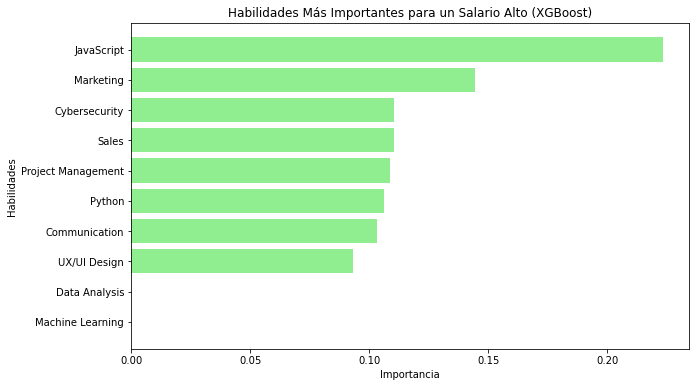

In [53]:
print("\nResultados para XGBoost:")
print(classification_report(y_test_skills, y_pred_xgb, target_names=['No Alto', 'Alto']))
#print(confusion_matrix(y_test_skills, y_pred_xgb))

# Importancia de características XGBoost
feature_importances_xgb = pd.DataFrame({
    'Skill': X_train_skills_balanced.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nHabilidades más importantes para un salario alto (XGBoost):")
print(feature_importances_xgb.head(10))

# Visualización de las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_xgb.head(10)['Skill'], feature_importances_xgb.head(10)['Importance'], color='lightgreen')
plt.xlabel('Importancia')
plt.ylabel('Habilidades')
plt.title('Habilidades Más Importantes para un Salario Alto (XGBoost)')
plt.gca().invert_yaxis()
plt.show()


### Comparación entre Random Forest y XGBoost


Comparación de métricas:
Random Forest - F1-Score: 0.2353, Precisión: 0.2000, Acuracidad: 0.4800, Roc_auc: 0.4206
XGBoost       - F1-Score: 0.2564, Precisión: 0.2000, Acuracidad: 0.4200, Roc_auc: 0.4008

XGBoost es el mejor modelo basado en F1-Score.


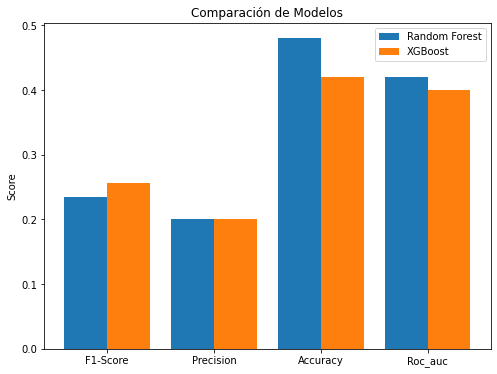

In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score

# Evaluación de métricas para Random Forest
f1_rf = f1_score(y_test_skills, y_pred_rf, pos_label=1)
precision_rf = precision_score(y_test_skills, y_pred_rf, pos_label=1)
accuracy_rf = accuracy_score(y_test_skills, y_pred_rf)
roc_auc_rf=roc_auc_score(y_test_skills, y_pred_rf)

# Evaluación de métricas para XGBoost
f1_xgb = f1_score(y_test_skills, y_pred_xgb, pos_label=1)
precision_xgb = precision_score(y_test_skills, y_pred_xgb, pos_label=1)
accuracy_xgb = accuracy_score(y_test_skills, y_pred_xgb)
roc_auc_xgb=roc_auc_score(y_test_skills, y_pred_xgb)

# Mostrar métricas de ambos modelos
print("\nComparación de métricas:")
print(f"Random Forest - F1-Score: {f1_rf:.4f}, Precisión: {precision_rf:.4f}, Acuracidad: {accuracy_rf:.4f}, Roc_auc: {roc_auc_rf:.4f}")
print(f"XGBoost       - F1-Score: {f1_xgb:.4f}, Precisión: {precision_xgb:.4f}, Acuracidad: {accuracy_xgb:.4f}, Roc_auc: {roc_auc_xgb:.4f}")

# Decidir el mejor modelo según F1-Score
if roc_auc_rf > roc_auc_xgb:
    print("\nRandom Forest es el mejor modelo basado en F1-Score.")
else:
    print("\nXGBoost es el mejor modelo basado en F1-Score.")

# Visualización comparativa (barras)
import numpy as np

# Crear un gráfico de barras para comparar métricas
metrics = ['F1-Score', 'Precision', 'Accuracy', 'Roc_auc']
rf_scores = [f1_rf, precision_rf, accuracy_rf, roc_auc_rf]
xgb_scores = [f1_xgb, precision_xgb, accuracy_xgb, roc_auc_xgb]

x = np.arange(len(metrics))  # Etiquetas para las métricas

plt.figure(figsize=(8, 6))
plt.bar(x - 0.2, rf_scores, width=0.4, label='Random Forest', align='center')
plt.bar(x + 0.2, xgb_scores, width=0.4, label='XGBoost', align='center')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Comparación de Modelos')
plt.legend()
plt.show()


>Aunque XGBoost tiene un F1-Score ligeramente superior, Random Forest es ligeramente mejor en general, ya que tiene una mayor acuracidad y un mejor ROC AUC. 

>No obstante, ambos modelos están mostrando un rendimiento subóptimo debido a la poca correlación entre las variables.

Seleccionamos **Random Forest** como modelo final

### Entrenamiento Final con Random Forest y Predicción

In [56]:
# Entrenar el modelo final con todos los datos de entrenamiento
final_rf_model = RandomForestClassifier(
    n_estimators=grid_search_rf.best_params_['n_estimators'],
    max_depth=grid_search_rf.best_params_['max_depth'],
    min_samples_split=grid_search_rf.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
    max_features=grid_search_rf.best_params_['max_features'],
    random_state=42
)

# Ajustar el modelo con todos los datos de entrenamiento balanceados
print("\nEntrenando el modelo final (Random Forest) con todos los datos de entrenamiento...")
final_rf_model.fit(X_train_skills_balanced, y_train_skills_balanced)

# Predecir con el conjunto de prueba
final_y_pred_rf = final_rf_model.predict(X_test_skills)




Entrenando el modelo final (Random Forest) con todos los datos de entrenamiento...


### Evaluación del modelo final


Resultados del modelo final (Random Forest):
              precision    recall  f1-score   support

     No Alto       0.67      0.56      0.61        72
        Alto       0.20      0.29      0.24        28

    accuracy                           0.48       100
   macro avg       0.43      0.42      0.42       100
weighted avg       0.54      0.48      0.50       100



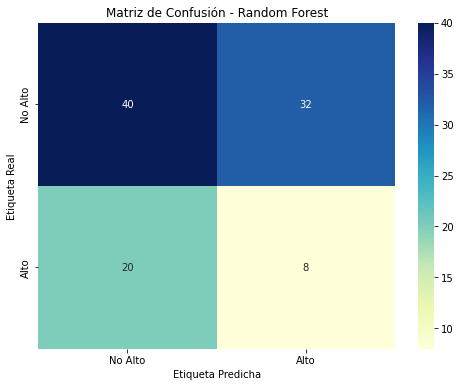

In [59]:
# Importar librerías necesarias
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Evaluación del Modelo: Classification Report

print("\nResultados del modelo final (Random Forest):")
print(classification_report(y_test_skills, final_y_pred_rf, target_names=['No Alto', 'Alto']))


# 2. Evaluación del Modelo: Matriz de Confusión

# Predecir etiquetas en el conjunto de prueba
y_pred_rf = best_rf_model.predict(X_test_skills)

# Crear matriz de confusión
cm_rf = confusion_matrix(y_test_skills, y_pred_rf)
class_names = ['No Alto', 'Alto']  # Nombres de las clases

# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm_rf, index=class_names, columns=class_names), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


- El modelo tiene más éxito en predecir la clase mayoritaria ("No Alto"), pero tiene serias dificultades para identificar correctamente la clase minoritaria ("Alto").

AUC del Modelo Random Forest: 0.422


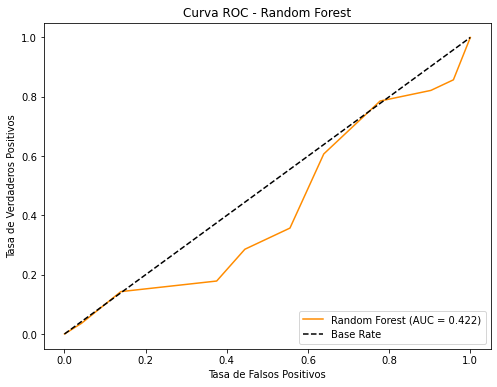

In [60]:
# 3. Evaluación AUC y Curva ROC
# Probabilidades de predicción para la clase positiva (Alto)
y_pred_proba_rf = best_rf_model.predict_proba(X_test_skills)[:, 1]

# Calcular el AUC
auc_rf = roc_auc_score(y_test_skills, y_pred_proba_rf)
print(f"AUC del Modelo Random Forest: {auc_rf:.3f}")

# Graficar la Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_skills, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.3f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Base Rate")
plt.title('Curva ROC - Random Forest')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="lower right")
plt.show()

- El valor de AUC es de 0.422, que está por debajo del 0.5 (modelo aleatorio). Esto indica que el modelo no es efectivo para distinguir entre las clases.


Habilidades más importantes para un salario alto (Modelo Final - Random Forest):
                Skill  Importance
3          JavaScript    0.362889
5           Marketing    0.171179
8               Sales    0.088425
6  Project Management    0.061482
4    Machine Learning    0.059557
0       Communication    0.058288
1       Cybersecurity    0.056615
9        UX/UI Design    0.050568
7              Python    0.045513
2       Data Analysis    0.045484


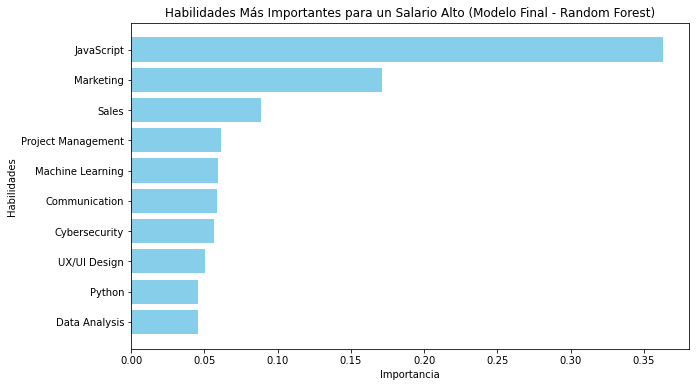

In [58]:
# Importancia de características en el modelo final
final_feature_importances_rf = pd.DataFrame({
    'Skill': X_train_skills_balanced.columns,
    'Importance': final_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nHabilidades más importantes para un salario alto (Modelo Final - Random Forest):")
print(final_feature_importances_rf.head(10))

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(final_feature_importances_rf.head(10)['Skill'], final_feature_importances_rf.head(10)['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Habilidades')
plt.title('Habilidades Más Importantes para un Salario Alto (Modelo Final - Random Forest)')
plt.gca().invert_yaxis()
plt.show()


Las habilidades más importantes para predecir un salario alto según el modelo son:

- JavaScript (0.362889): La habilidad más relevante en el análisis, con una importancia notablemente superior a las demás.
- Marketing (0.171179): Segunda habilidad más importante, pero con una importancia mucho menor en comparación con JavaScript.
- Sales (0.084425): También contribuye, pero menos significativamente.
- Project Management (0.061482) y Machine Learning (0.055957): Representan habilidades técnicas y de gestión con impactos más pequeños.

Nota: La importancia de habilidades como JavaScript y Marketing puede estar sesgada por la representación de estas habilidades en los datos.

## Conclusiones

1. El modelo tiene un rendimiento limitado. Las métricas generales (accuracy, F1-Score, AUC) son bajas, especialmente para la clase "Alto". Esto podría deberse a:

- Desequilibrio de clases: La clase "Alto" está subrepresentada.
- Información insuficiente: Las características utilizadas podrían no ser suficientemente discriminativas para la predicción.

2. La importancia de características destaca sesgos potenciales: La gran importancia atribuida a JavaScript podría reflejar un patrón en los datos más que una relación real con salarios altos.


## **Plan Estratégico para Incrementar las Oportunidades Salariales**

#### **Desarrollo de un Sistema de Recomendación Personalizado**
Crear un sistema basado en los resultados del modelo que:
- Analice el perfil de un candidato (habilidades actuales).
- Recomiende habilidades clave a desarrollar, priorizando aquellas con mayor impacto en los salarios altos.

Ejemplo:
- Si un profesional tiene experiencia en Python y Machine Learning pero carece de habilidades gerenciales, el sistema recomendaría cursos de **Marketing** y **Project Management**.




## Predicción 3. Factores de automatización

> Predecir que puestos de trabajo tienen riesgo de automatización o no según el resto de características: localización, habilidades....


In [40]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Semilla fija para reproducibilidad
seed = 42

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Lista de modelos de clasificación a evaluar
models = []
models.append(('Logistic Regression', LogisticRegression(random_state=seed)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, random_state=seed)))
models.append(('Decision Tree', DecisionTreeClassifier(random_state=seed)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('XGBoost', XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')))

# Evaluar cada modelo
results = []
model_names = []

for name, model in models:
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Guardar resultados
    results.append((name, accuracy, precision, recall, f1))
    model_names.append(name)

# Mostrar los resultados
print("Modelo\t\t\t Accuracy\t Precision\t Recall\t\t F1")
for name, accuracy, precision, recall, f1 in results:
    print(f"{name:<20} {accuracy:.3f}\t\t {precision:.3f}\t\t {recall:.3f}\t\t {f1:.3f}")


Modelo			 Accuracy	 Precision	 Recall		 F1
Logistic Regression  0.680		 0.680		 1.000		 0.810
Random Forest        0.640		 0.674		 0.912		 0.775
Decision Tree        0.530		 0.657		 0.647		 0.652
KNN                  0.540		 0.631		 0.779		 0.697
SVM                  0.680		 0.680		 1.000		 0.810
XGBoost              0.620		 0.688		 0.809		 0.743



>Las conclusiones de estas metricas son que el Random Forest es una la mejor elección para este problema de clasificación porque logra un equilibrio entre precision (0.674) y recall (0.912), lo que resulta en un F1-score sólido (0.775). Dado que en problemas de clasificación es importante minimizar los errores de tipo positivo y negativo, Random Forest, al ser un modelo robusto basado en múltiples árboles de decisión, reduce el riesgo de sobreajuste y captura relaciones no lineales en los datos, lo que lo hace ideal para esta tarea.

No elegimos Logistic Regression porque su baja precisión (0.680) implica muchos falsos positivos, lo que puede ser costoso. Decision Tree tiene el peor rendimiento general (F1 = 0.652) y es propenso al sobreajuste. KNN tiene un recall es bajo (0.697), lo que significa que pierde casos positivos importantes. SVM y XGBoost son equilibrados, pero no superan a Random Forest en recall ni robustez, por lo que Random Forest es la mejor opción para capturar patrones complejos y minimizar errores.

Los modelos tienen un rendimiento moderado; Random Forest destaca, pero las metricas no son ideales. Esto indica que los modelos podrían mejorarse mediante mejor ingeniería de características, optimización de hiperparámetros y tratamiento de posibles problemas en los datos (como ruido o desbalance). Aunque útiles como punto de partida, aún hay margen para obtener predicciones más precisas y robustas.

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.25      0.06      0.10        32
           1       0.67      0.91      0.78        68

    accuracy                           0.64       100
   macro avg       0.46      0.49      0.44       100
weighted avg       0.54      0.64      0.56       100

Matriz de Confusión:
[[ 2 30]
 [ 6 62]]
Características más importantes para el riesgo de automatización:
                            Feature  Importance
0                        Salary_USD    0.160389
41              Remote_Friendly_Yes    0.032356
30            AI_Adoption_Level_Low    0.032093
19              Company_Size_Medium    0.031419
43     Job_Growth_Projection_Stable    0.030101
31         AI_Adoption_Level_Medium    0.029991
20               Company_Size_Small    0.027781
42     Job_Growth_Projection_Growth    0.025563
38           Required_Skills_Python    0.022465
1   Job_Title_Cybersecurity Analyst    0.022055


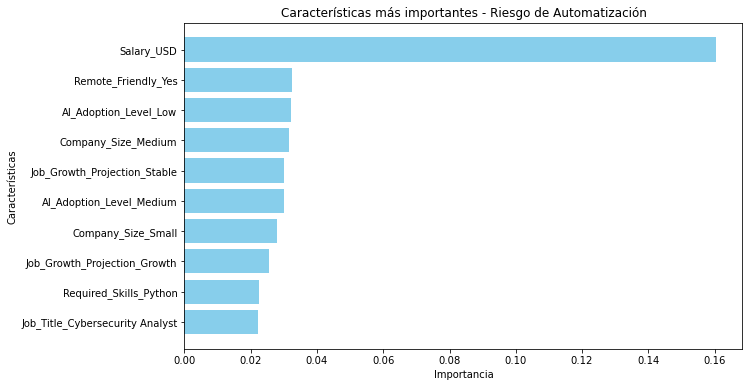

In [38]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. Cargar los datos
data = pd.read_csv('ai_job_market_insights.csv')  # Cambia la ruta si es necesario

# 2. Convertir "Automation_Risk" en una variable binaria
# (1: High o Medium riesgo, 0: Low riesgo)
data['Automation_Risk_Binary'] = data['Automation_Risk'].apply(lambda x: 1 if x in ['High', 'Medium'] else 0)

# 3. Preprocesar los datos
# Eliminar columnas irrelevantes o redundantes
X = data.drop(columns=['Automation_Risk', 'Automation_Risk_Binary'])  # Mantén solo las características relevantes
y = data['Automation_Risk_Binary']

# Convertir variables categóricas a dummies
X = pd.get_dummies(X, drop_first=True)

# Guardar los nombres de las columnas antes de escalar
feature_names = X.columns

# Escalar características numéricas (opcional, si los datos lo requieren)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Transformar pero conservar el orden

# 4. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Entrenar un modelo de Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 6. Evaluar el modelo
y_pred = model.predict(X_test)

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# 7. Analizar la importancia de las características
feature_importances = pd.DataFrame({
    'Feature': feature_names,  # Usar los nombres originales de las columnas
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Características más importantes para el riesgo de automatización:")
print(feature_importances.head(10))

# 8. Graficar las características más importantes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='skyblue')
plt.gca().invert_yaxis()  # Invertir el eje para que las más importantes estén arriba
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Características más importantes - Riesgo de Automatización')
plt.show()


>El modelo Random Forest obtuvo una accuracy de 0.64, indica que el modelo clasifica correctamente el 64% de los casos. Aunque puede parecer razonable, no es suficiente si el problema requiere alta precisión en ambas clases (bajo y alto riesgo).

Tiene un buen recall para la clase 1 (0.91), lo que indica que detecta correctamente la mayoría de los casos de alto/medio riesgo de automatización. Sin embargo, el recall para la clase 0 (0.06) y su baja precision (0.25) muestran que falla al identificar correctamente los casos de bajo riesgo.

El balance entre precisión y recall para la clase de alto riesgo es aceptable, pero el rendimiento general del modelo se ve afectado por el bajo F1 para la clase 0 (0.10)

Respecto a la matriz de confusión:
- El modelo clasifica correctamente 62 casos de alto riesgo y solo 2 de bajo riesgo.
- Falla al identificar 30 casos de bajo riesgo y tiene 6 falsos negativos en la clase de alto riesgo. Este desequilibrio muestra que el modelo está sesgado hacia la clase mayoritaria (clase 1).

El modelo no es ideal debido al desequilibrio en las clases, sesgado hacia la clase 1, lo que se debe principalmente a que no siempre los datos de partida son adecuados para construir un modelo predictivo sólido, ya sea porque están desequilibrados, tienen ruido o las características no discriminan correctamente entre las clases.

¿Y que se podría mejorar? Usar técnicas como sobremuestreo (SMOTE) o submuestreo para equilibrar las clases, ajustar parámetros como class_weight en Random Forest o realizar una búsqueda de hiperparámetros con GridSearchCV.


### **Análisis de Resultados del Modelo de Clasificación para el Riesgo de Automatización**

#### **Métricas de Desempeño**

1. **Accuracy General**:
   - El modelo tiene una **exactitud global del 64%**, lo que significa que predice correctamente el riesgo de automatización (alto o bajo) en el 64% de los casos.

2. **Precisión**:
   - **Clase 0 (Bajo Riesgo)**: La precisión para esta clase es **0.25**, lo que indica que, cuando el modelo predice bajo riesgo, solo el 25% de las veces es correcto.
   - **Clase 1 (Alto Riesgo)**: La precisión es significativamente mayor, alcanzando **0.67**.

3. **Recall**:
   - **Clase 0 (Bajo Riesgo)**: El modelo tiene un recall de **0.06**, lo que significa que solo detecta el 6% de los casos de bajo riesgo correctamente.
   - **Clase 1 (Alto Riesgo)**: El recall es **0.91**, lo que indica que identifica correctamente el 91% de los casos de alto riesgo.

4. **F1-Score**:
   - **Clase 0 (Bajo Riesgo)**: El F1-Score de **0.10** refleja un desempeño deficiente para esta clase, influido por el bajo recall y precisión.
   - **Clase 1 (Alto Riesgo)**: El F1-Score de **0.78** muestra un desempeño sólido para esta clase.

5. **Matriz de Confusión**:
   - El modelo tiene **30 falsos positivos** (predice alto riesgo cuando no lo es) y **6 falsos negativos** (predice bajo riesgo cuando es alto riesgo). Esto sugiere un sesgo hacia la clase mayoritaria (Alto Riesgo).



### **Conclusiones**

1. **Rendimiento del Modelo**:
   - El modelo tiene un desempeño razonable para la clase mayoritaria (**Alto Riesgo**), pero es deficiente para la clase minoritaria (**Bajo Riesgo**).
   - Esto indica un posible desequilibrio en las clases, lo cual afecta negativamente el desempeño en la clase de bajo riesgo.

2. **Factores Clave**:
   - El salario, el trabajo remoto y el nivel de adopción de IA son las características más influyentes en el riesgo de automatización.
   - Las habilidades técnicas, como Python y roles especializados, contribuyen a mitigar el riesgo de automatización.

3. **Limitaciones Identificadas**:
   - El modelo tiene problemas para identificar correctamente los casos de bajo riesgo, como lo refleja el bajo recall y F1-score para la clase 0.


